Building ChatBot with Multiple tools using LangGraph

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [31]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
## from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_tavily import TavilySearch
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage, AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from pprint import pprint

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


In [21]:
#Arxiv Wrapper 
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

#Wikipedia Wrapper
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

#Taviliy search tool
tavily = TavilySearch()


In [23]:
##Custom Functions

def multiply(a: int, b: int) -> int:
    """Multiply a and b

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Add a and b

    Args:
        a: first int
        b: second int
    """
    return a + b

def divde(a: int, b: int) -> float:
    """Divide a by b

    Args:
        a: first int
        b: second int
    """
    return a/b

tools = [arxiv,wiki,tavily,multiply,add,divde]

In [ ]:
#Initialize LLM Model
groq_llm = ChatGroq(
    model = "qwen/qwen3-32b"
)

llm_with_tools = groq_llm.bind_tools(tools)
#llm_with_tools.invoke([HumanMessage(content="what is the recent Maharshtra Politics News")]).tool_calls

[{'name': 'tavily_search',
  'args': {'query': 'Maharashtra Politics',
   'search_depth': 'advanced',
   'time_range': 'week',
   'topic': 'news'},
  'id': 'tgxs8e7yp',
  'type': 'tool_call'}]

In [32]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]


##Node Definition
def tool_calling_llm(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

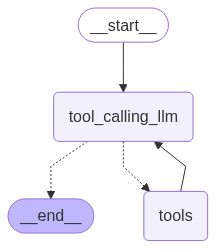

In [35]:
#Build Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools","tool_calling_llm")

graph = builder.compile()

#view 
display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
query = "which year world war 2 ended, add 20 in that number and then tell me important news of the new year"
result = graph.invoke({"messages":HumanMessage(content=query)})

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

which year world war 2 ended, add 20 in that number and then tell me important news of the new year
================================== Ai Message ==================================
Tool Calls:
  wikipedia (6z8mdftfn)
 Call ID: 6z8mdftfn
  Args:
    query: World War 2 end year
================================= Tool Message =================================
Name: wikipedia

Page: End of World War II in Europe
Summary: The end of World War II in Europe occurred in May 1945. Following the suicide of Adolf Hitler on 30 April, leadership of Nazi Germany passed to Grand Admiral Karl Dönitz and the Flensburg Government. Soviet troops conquered Berlin on 2 May, and a number of German military forces surrendered over the next few days. On 8 May, Field Marshal Wilhelm Keitel signed the German Instrument of Surrender, an unconditional surrender to the Allies, in Karlshorst, 
================================== Ai Mess